In [17]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io.votable import parse
from astropy.io.votable import parse_single_table
import matplotlib.patches as patches

In [18]:
# Data Paths
hyades_data_dir = 'Data/TestData7.vot' # Path to data here

<h1>Extracting data from the .VOT file</h1>

In [19]:
# Create a table from the data
table = parse_single_table(hyades_data_dir)
print(table.fields)
data = table.array

"""
FIELD ID="ra" datatype="double" name="ra" ucd="pos.eq.ra;meta.main" unit="deg"
FIELD ID="pmra" datatype="float" name="pmra" unit="mas / yr"/
FIELD ID="radial_velocity" datatype="float" name="radial_velocity" unit="km / s"
"""

[<FIELD ID="tycho2sources_oid" datatype="int" name="tycho2sources_oid"/>, <FIELD ID="id" arraysize="*" datatype="char" name="id"/>, <FIELD ID="hip" datatype="int" name="hip"/>, <FIELD ID="ra" datatype="double" name="ra" ucd="pos.eq.ra;meta.main" unit="deg" utype="Char.SpatialAxis.Coverage.Location.Coord.Position2D.Value2.C1"/>, <FIELD ID="dec" datatype="double" name="dec" ucd="pos.eq.dec;meta.main" unit="deg" utype="Char.SpatialAxis.Coverage.Location.Coord.Position2D.Value2.C2"/>, <FIELD ID="pmra" datatype="float" name="pmra" unit="mas / yr"/>, <FIELD ID="pmdec" datatype="float" name="pmdec" unit="mas / yr"/>, <FIELD ID="pmra_error" datatype="float" name="pmra_error" unit="mas / yr"/>, <FIELD ID="pmdec_error" datatype="float" name="pmdec_error" unit="mas / yr"/>, <FIELD ID="radial_velocity" datatype="float" name="radial_velocity" ucd="spect.dopplerVeloc.opt;em.opt.I" unit="km / s" utype="stc:AstroCoords.Velocity3D.Value3.C3"/>]


'\nFIELD ID="ra" datatype="double" name="ra" ucd="pos.eq.ra;meta.main" unit="deg"\nFIELD ID="pmra" datatype="float" name="pmra" unit="mas / yr"/\nFIELD ID="radial_velocity" datatype="float" name="radial_velocity" unit="km / s"\n'

# Useful Functions

In [20]:
def get_cond(pmra_range, pmdec_range):
    """
    Define condition based on ranges of dec and ra
    """
    cond = ((data['pmra'] > pmra_range[0]) & (data['pmra'] < pmra_range[1]) & (data['pmdec'] > pmdec_range[0]) & (data['pmdec'] < pmdec_range[1]))
    return cond

In [21]:
def plot_selected_pm(data, cond):
    """
    Selects proper motion of members based on given conidtion and data. Plots the selected members' pm.
    Returns selected members' pm
    """
    selected_data = data[cond]
    selected_pmra = data['pmra'][cond]
    selected_pmdec = data['pmdec'][cond]
    
    plt.plot(data['pmra'], data['pmdec'], '.', label='Field', alpha=.8, markersize=5, )
    plt.plot(selected_pmra, selected_pmdec, '+', label='Hyades', alpha=.7,markersize=8,)
    plt.xlim(-150, 200)
    plt.ylim(-150, 100)

    plt.xlabel('Proper Motion in RA (mas/yr)')
    plt.ylabel('Proper Motion in DEC (mas/yr)')
    plt.legend()
    plt.savefig(f'pm_cluster.jpg', dpi=600)
    plt.show()
    return selected_pmra, selected_pmdec, selected_data

def plot_selected_coords(data, cond):
    """
    Selects the cluster members' coords based on a condition and given data. Plots selected coords.
    Returns selected members' coords.
    """
    selected_ra = data['ra'][cond]
    selected_dec = data['dec'][cond]

    plt.plot(data['ra'], data['dec'],  '.', label='Field', alpha=.8, markersize=4)
    plt.plot(selected_ra, selected_dec, '+', label='Hyades', alpha=1,markersize=8)

    plt.xlabel('RA (deg)')
    plt.ylabel('DEC (deg)')
    
    plt.legend()
    plt.show()
    return selected_ra, selected_dec

## Inspect the Proper Motion Data
We want to select the members of the Hyades cluster using proper motion data - let us inspect this first

Text(0, 0.5, 'Proper Motion in DEC (mas/yr)')

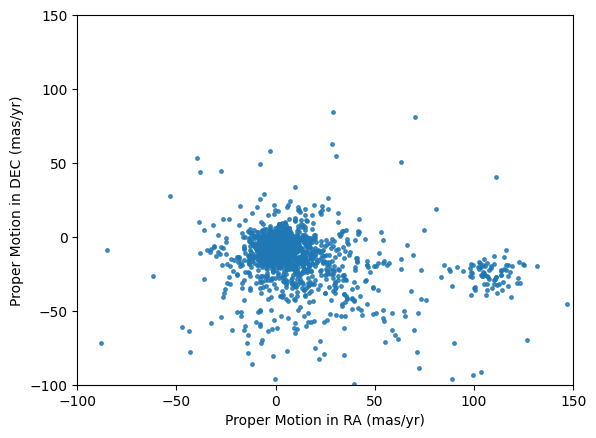

In [22]:
plt.plot(data['pmra'], data['pmdec'], '.', label='Field', alpha=.8, markersize=5)
plt.xlim(-100, 150)
plt.ylim(-100, 150)

plt.xlabel('Proper Motion in RA (mas/yr)')
plt.ylabel('Proper Motion in DEC (mas/yr)')

As we can see from the plot, there is a cluster at ~ (-100, -25). This is likely the stars from the Hyades cluster, so we will select them for our analysis

<h2>Selecting Members Using Proper Motions</h2>
We define the conditions to select the data from our visual inspection and select the stars using this.

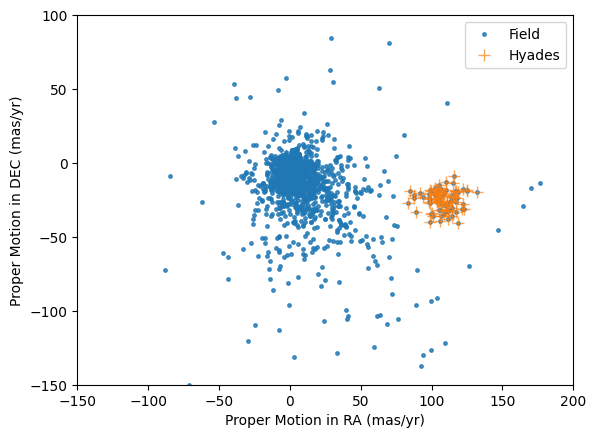

In [23]:
# count+=1
plt.close()

# Define ranges of pm
pmra_range = (80, 132) # Range of proper motions in ra that correspond to members
pmdec_range = (-45, -8) # Range of proper motions in dec that correspond to members

# Define a condition based on the ranges
cond = get_cond(pmra_range, pmdec_range)

selected_pmra, selected_pmdec, selected_data = plot_selected_pm(data, cond)

## How does the positional distribution look?

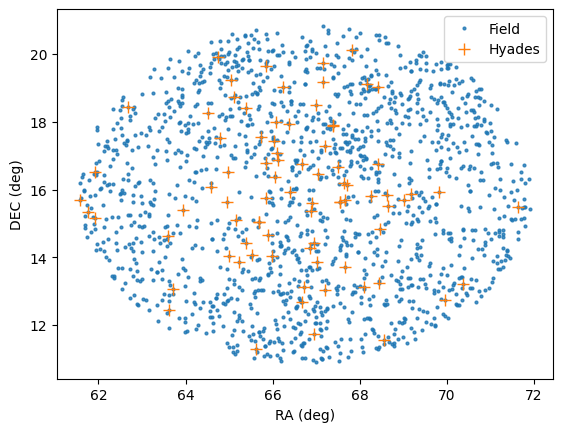

In [24]:
plt.close()
selected_ra, selected_dec = plot_selected_coords(data, cond)

<h2>Getting to the Convergent Point</h2>
We define below a function that will calculate the convergent point from our data. We do this by extending the motion of the stars using their proper motion. The point of 'intersection' is calculated by scanning across the RA and DEC coordinates and calculating the variance and selecting the point at which they are the minimum.

81
(96.26262626262627, 8.84848484848485)
13.596849748040263 0.6231149510078832
Total var: 15.782867399765674


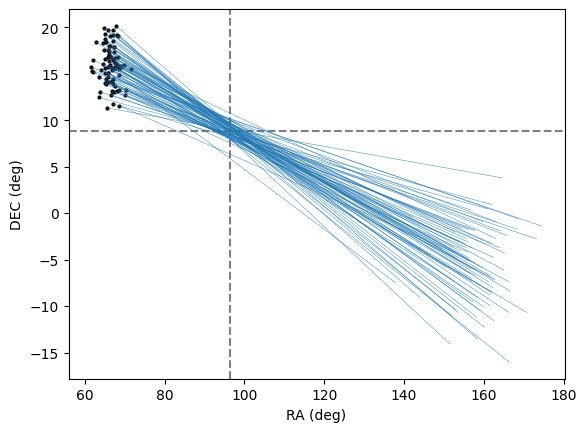

In [28]:
def CP_members(member_ra, member_dec, member_pmra, member_pmdec, t_tot = 10**6.5, patch=False):
    fig = plt.figure()
    ax = fig.subplots(1)
    ax.plot(member_ra, member_dec, 'k.', markersize=4)
    
    # Simulate the path of the star in RA and DEC by assuming constant proper motion
    member_ra_final = member_ra + member_pmra * t_tot * 2.7e-7 
    member_dec_final = member_dec + member_pmdec * t_tot * 2.7e-7
    
    # Create arrays that represent the ra and dec values we want to scan across
    min_ra, max_ra = 70, 120 
    min_dec, max_dec = 0, 12
    n_bins = 100
    ra_vals = np.linspace(min_ra, max_ra, n_bins)
    dec_vals = np.linspace(min_dec, max_dec, n_bins)

    # For each value in ra_vals, calculate dec of each member
    interped_dec = []
    interped_ra = []
    
    for i in range(len(member_ra)):
        interped_dec.append(np.interp(ra_vals, [member_ra[i], member_ra_final[i]], [member_dec[i], member_dec_final[i]]))
        # ax.plot(ra_vals, interped_dec[i], linestyle='dashed')
        interped_ra.append(np.interp(dec_vals, [member_dec_final[i], member_dec[i]], [member_ra_final[i], member_ra[i]]))
        # ax.plot(interped_ra[i], dec_vals, linestyle='dashed')
    
    var_dec = np.var(interped_dec, axis=0)
    ax.axvline(ra_vals[np.argmin(var_dec)], linestyle='dashed', color='grey')
    var_ra = np.var(interped_ra, axis=0)
    ax.axhline(dec_vals[np.argmin(var_ra)], linestyle='dashed', color='grey')
    CP = (ra_vals[np.argmin(var_dec)], dec_vals[np.argmin(var_ra)])
    print(CP)
    
    # Errors
    print(np.min(var_ra), np.min(var_dec))
    total_var = np.sqrt((np.min(var_ra) / CP[0])**2 + (np.min(var_dec) / CP[1])**2)
    print('Total var:', total_var * 100)
    
    for i in range(len(member_ra)):
        ax.plot([member_ra_final[i], member_ra[i]], [member_dec_final[i], member_dec[i]], 'tab:blue', linewidth=0.3)
    # plt.xlim(-150, 200)
    # plt.ylim(-150, 100)

    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('DEC (deg)')
    fig.savefig('CP_cluster.jpg', dpi=600)

              
    if patch:
        ax.add_patch(rect)
    # fig.show()
    fig.savefig('CP_cluster.png')
    return CP, var_ra, var_dec

plt.close()
CP, var_ra, var_dec = CP_members(selected_ra, selected_dec, selected_pmra, selected_pmdec)

<h2>Calculating Distances</h2>
We can now calculate distances to the individual stars using the convergent point

In [29]:
def calc_individual_dist(members_ra, members_dec, members_pmra, members_pmdec, rad_vel, CP):
    CP_RA = CP[0]
    CP_DE = CP[1]
    theta = np.arccos(np.sin(np.deg2rad(members_dec)) * np.sin(np.deg2rad(CP_DE)) + np.cos(np.deg2rad(members_dec)) 
                      * np.cos(np.deg2rad(CP_DE)) * np.cos(np.deg2rad(members_ra) - np.deg2rad(CP_RA)))
    # print(theta)
    pm_abs = np.sqrt(members_pmra**2 + members_pmdec**2)
    dist = (rad_vel * np.tan(theta)) / (4.74047 * pm_abs)
    avg_dist_pc = dist.mean() * 1000
    return avg_dist_pc

In [30]:
ConvPoint_avg = CP # Convergent point in RA, DEC 
avg_dist = calc_individual_dist(selected_ra, selected_dec, selected_pmra, selected_pmdec, selected_data['radial_velocity'], ConvPoint_avg)
print('Average Distance to CLuster (pc):', int(avg_dist.round(0)))

Average Distance to CLuster (pc): 44
